In [1]:
import keras
import librosa
import python_speech_features
from scipy.io import wavfile
import numpy as np
from timeit import default_timer as timer
from pathlib import Path
import IPython.display as ipd
from pydub import AudioSegment

def get_audio(path, sample_rate=16000):
    wav, wav_sr = librosa.load(path, sr=sample_rate)
    if wav.size < 16000:
        return np.pad(wav, (16000 - wav.size, 0), mode='constant')
    else:
        return wav[0:16000]

# compute MFCC features from audio signal
def audio2feature(audio):
    audio = audio.astype(np.float)
    # normalize data
    audio -= audio.mean()
    audio /= np.max((audio.max(), -audio.min()))
    # compute MFCC coefficients
    features = python_speech_features.mfcc(audio, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40,
                                           nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22,
                                           appendEnergy=True, winfunc=np.hamming)
    return features

def extract_loudest_section(audio, length):
    audio = audio[:, 0].astype(np.float) # to avoid integer overflow when squaring
    audio_pw = audio**2 # power
    window = np.ones((length, ))
    conv = np.convolve(audio_pw, window, mode="valid")
    begin_index = conv.argmax()
    return audio[begin_index:begin_index+length]


def signaltonoise(command, noise):
    c = np.mean(command)
    n = np.mean(noise)

    return np.abs(c / n)


def get_nr_noises(path, samples_nr):
    ''' Returns paths to noise samples.'''
    datadir = Path(path)
    files = [str(f) for f in datadir.glob('**/*.wav') if f]
    return files[0:samples_nr]

Using TensorFlow backend.
d:\a__a\projects\szum\venv\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
d:\a__a\projects\szum\venv\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
d:\a__a\projects\szum\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or 

In [ ]:
wav = get_audio('data_new/training/bed/0c2ca723_nohash_1.wav')
bg = get_audio('noise/a001_80_90.wav')
start_ = np.random.randint(bg.shape[0]-16000)
bg_slice = bg[start_ : start_+16000]
wav_with_bg = wav * np.random.uniform(0.8, 1.2) + \
              bg * np.random.uniform(0, 1)

librosa.output.write_wav(path="output2.wav", y=wav_with_bg, sr=16000 )
 

from playsound import playsound

playsound("output2.wav")

In [2]:
from IPython.display import clear_output
from tensorflow import keras

audio_buffer = np.zeros((5, 3200))
last_recognized_word = None
last_recognition_time = 0
recognition_timeout = 1.0
word2index = {
    # core words
    "yes": 0,
    "no": 1,
    "up": 2,
    "down": 3,
    "left": 4,
    "right": 5,
    "on": 6,
    "off": 7,
    "stop": 8,
    "go": 9,
    "unknown": 10
}
index2word = [word for word in word2index]
model = keras.models.load_model("models/model_January_16/model.11.hdf5")

def audio_stream_callback(indata, frames, time, status):
    global audio_buffer
    global model
    global index2word
    global last_recognized_word
    global last_recognition_time
    audio_buffer = np.roll(audio_buffer, shift=-1, axis=0)
    audio_buffer[-1, :] = np.squeeze(indata)
    recorded_feature = audio2feature(audio_buffer.flatten())
    recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
    prediction = model.predict(recorded_feature).reshape((11, ))
    # normalize prediction output to get "probabilities"
    prediction /= prediction.sum()
    best_candidate_index = prediction.argmax()
    best_candidate_probability = prediction[best_candidate_index]
    
    if(best_candidate_probability > 0.5): # treshold
        word = index2word[best_candidate_index]
        if( (timer()-last_recognition_time)>recognition_timeout or word!=last_recognized_word ):
            last_recognition_time = timer()
            last_recognized_word = word
            clear_output(wait=True) # clear ouput as soon as new output is available to replace it
            print("%s\t:\t%2.1f%%" % (word, best_candidate_probability*100))
            print("-----------------------------")


In [6]:
import sounddevice as sd
# REALTIME KEYWORD RECOGNITION DEMO (60s long)
with sd.InputStream(samplerate=16000, blocksize=3200, device=None, channels=1, dtype="float32", callback=audio_stream_callback):
    sd.sleep(60*1000)


unknown	:	78.4%
-----------------------------


In [11]:
import matplotlib
import numpy as np
import librosa
from tensorflow import keras
from pathlib import Path
from tqdm import tqdm
# %matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy import signal


def get_audio(path, sample_rate=16000):
    wav, wav_sr = librosa.load(path, sr=sample_rate)
    if wav.size < 16000:
        return np.pad(wav, (16000 - wav.size, 0), mode='constant')
    else:
        return wav[0:16000]

word2index = {
    # core words
    "yes": 0,
    "no": 1,
    "up": 2,
    "down": 3,
    "left": 4,
    "right": 5,
    "on": 6,
    "off": 7,
    "stop": 8,
    "go": 9,
    "unknown": 10
}

def signaltonoise(command, noise):
    c = np.mean(command)
    n = np.mean(noise)

    return np.abs(c / n)


def get_nr_noises(path, samples_nr):
    ''' Returns paths to noise samples.'''
    datadir = Path(path)
    files = [str(f) for f in datadir.glob('**/*.wav') if f]
    return files[0:samples_nr]

def get_data(path):
    ''' Returns dataframe with columns: 'path', 'word'.'''
    datadir = Path(path)
    files = [(str(f), f.parts[-2]) for f in datadir.glob('**/*.wav') if f]
    df = pd.DataFrame(files, columns=['path', 'word'])

    return df


def prepare_data(df):
    '''Transform data into something more useful.'''
    train_words = ['yes', 'no', 'up', 'down',
                   'left', 'right', 'on', 'off', 'stop', 'go']

    df.loc[~df.word.isin(train_words), 'word'] = 'unknown'
    return df

def get_specgram(audio):
    data = signal.spectrogram(audio, nperseg=256, noverlap=128)[2]
    # print(data.shape)
    return data

index2word = [word for word in word2index]
print(index2word)

print("loading dataset...")
# train = prepare_data(get_data('/macierz/home/s165554/pg/szum/data/evaluation/'))
test = prepare_data(get_data('../data/orginal/evaluation'))
# noises = get_nr_noises("../data/noise", len(test))
noises = None
with_noise = False
model = keras.models.load_model("models/model_with_get_specgram/model.17.hdf5")

samples = []
classes = []
snr = []

for class_name in test.word:
    classes.append(word2index[class_name])
classes = np.array(classes, dtype=np.int)

test = np.array(test.path)
snr_ratio = 0.25
# 5, 4, 3, 2, 1, 0.5, 0.33, 0.25, 0.20

for id, path in tqdm(enumerate(test)):
    command = get_audio(path)
    samples.append(command)

test = np.array(samples)
classes = np.array(classes, dtype=np.int)

correct = 0
predicted = []

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown']
loading dataset...


6459it [00:04, 1578.13it/s]


TOP1 acc = 0.7592506579965939


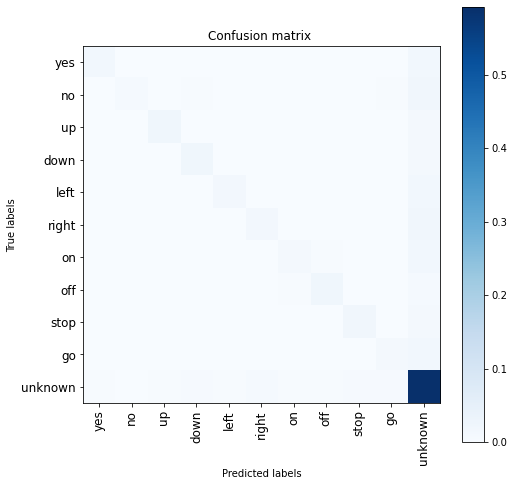

In [14]:
correct = 0
predicted = []

for id, rec in enumerate(test):
    recorded_feature = get_specgram(rec)

    recorded_feature = np.expand_dims(recorded_feature, 0)  # add "fake" batch dimension 1
    prediction = model.predict(recorded_feature).reshape((11,))

    # normalize prediction output to get "probabilities"
    prediction /= prediction.sum()
    max_class_id = prediction.argmax()
    # print the 3 candidates with highest probability
    predicted.append(max_class_id)
    #print("candidates:\n------------  " + index2word[classes[id]])
    #print("SNR = " + str(snr[id])))
    if index2word[max_class_id] == index2word[classes[id]]:
        correct += 1

    #print("-----------------------------")

acc = correct / len(samples)
print("TOP1 acc = " + str(acc))
cm = confusion_matrix(classes, predicted, normalize="all")
%matplotlib inline
plt.close()
plt.figure(figsize = (8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(0, 11, 1), index2word, rotation=90)
plt.yticks(np.arange(0, 11, 1), index2word)
plt.tick_params(labelsize=12)
plt.title('Confusion matrix ')
plt.colorbar()
plt.savefig('origin_dataset.png')
plt.show()

In [9]:
print(predicted)

[7, 8, 8, 2, 7, 7, 2, 7, 2, 7, 5, 2, 7, 7, 8, 8, 2, 8, 2, 7, 2, 8, 8, 8, 7, 2, 2, 2, 1, 8, 2, 7, 7, 7, 8, 7, 7, 6, 5, 8, 8, 2, 7, 7, 2, 2, 2, 7, 2, 7, 2, 2, 2, 7, 8, 7, 2, 2, 8, 8, 2, 2, 8, 7, 2, 8, 6, 8, 7, 7, 3, 7, 7, 7, 2, 2, 2, 7, 2, 7, 2, 2, 5, 8, 8, 7, 7, 2, 2, 7, 6, 2, 2, 8, 6, 8, 2, 2, 7, 7, 8, 6, 7, 8, 2, 2, 7, 7, 2, 8, 8, 0, 8, 2, 0, 7, 8, 2, 7, 7, 2, 6, 7, 7, 2, 2, 8, 7, 7, 2, 8, 2, 2, 8, 7, 7, 7, 7, 7, 7, 2, 7, 2, 2, 7, 2, 3, 8, 8, 6, 8, 7, 7, 7, 2, 2, 8, 8, 3, 2, 7, 2, 7, 8, 2, 2, 2, 6, 3, 7, 8, 2, 0, 2, 8, 2, 0, 0, 7, 7, 2, 8, 8, 7, 2, 8, 7, 8, 3, 7, 2, 2, 2, 0, 0, 6, 0, 0, 7, 0, 8, 7, 2, 2, 0, 0, 0, 2, 0, 7, 7, 2, 0, 0, 2, 3, 0, 7, 2, 7, 2, 2, 0, 7, 2, 7, 0, 2, 0, 8, 7, 6, 8, 7, 7, 2, 0, 2, 8, 0, 2, 7, 2, 2, 2, 0, 2, 7, 7, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 7, 0, 0, 0, 2, 2, 7, 7, 7, 7, 0, 7, 7, 8, 8, 0, 0, 0, 0, 0, 2, 0, 2, 7, 8, 2, 0, 8, 0, 8, 2, 8, 0, 0, 7, 2, 0, 2, 0, 8, 0, 2, 2, 0, 7, 2, 2, 0, 0, 8, 0, 7, 2, 7, 7, 0, 0, 0, 2, 7, 7, 2, 0, 2, 2, 0, 2, 7, 7, 2, 7, 8, 0, 8, 

<Figure size 432x288 with 0 Axes>